# Семинар. Автоэнкодеры

Напишем свой "простенький" автоэнкодер с нуля. Разберем создание этой архитектуры с нуля, обучим. В качестве домашнего задания вам предстоит модифицировать эту архитектуру до вариационного автокодировщика.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

## Dataset

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [4]:
dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

## Model

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, dim_code=32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(in_features=6272, out_features=dim_code)
        )
        self.decode_input = nn.Linear(in_features=dim_code, out_features=128*7*7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,  stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3,  stride=2, output_padding=1),
            nn.LeakyReLU()
        )

    def decode(self, x):
        to_decoder = self.decode_input(x)
        to_decoder = to_decoder.view(-1, 128, 7, 7)
        reconstruction = self.decoder(to_decoder)
        return reconstruction

    def forward(self, x):
        latent_code = self.encoder(x)
        to_decoder = self.decode_input(latent_code)
        to_decoder = to_decoder.view(-1, 128, 7, 7)
        reconstruction = self.decoder(to_decoder)

        return reconstruction, latent_code

## Training

In [6]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []

    for i in range(epochs):
        model.to(device)
        model.train()
        train_epoch_loss = []

        for batch in tqdm(dataloader):
            images, _ = batch

            optimizer.zero_grad()
            pred = model(images.to(device))
            reconstructed = pred[0]
            loss = criterion(reconstructed, images.to(device))
            loss.backward()
            optimizer.step()
        train_epoch_loss.append(loss.item())

        train_loss.append(np.mean(train_epoch_loss))
    return train_loss

In [7]:
criterion = nn.MSELoss()
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)
epochs = 20
device = 'mps'

100%|██████████| 7500/7500 [17:25<00:00,  7.17it/s]   


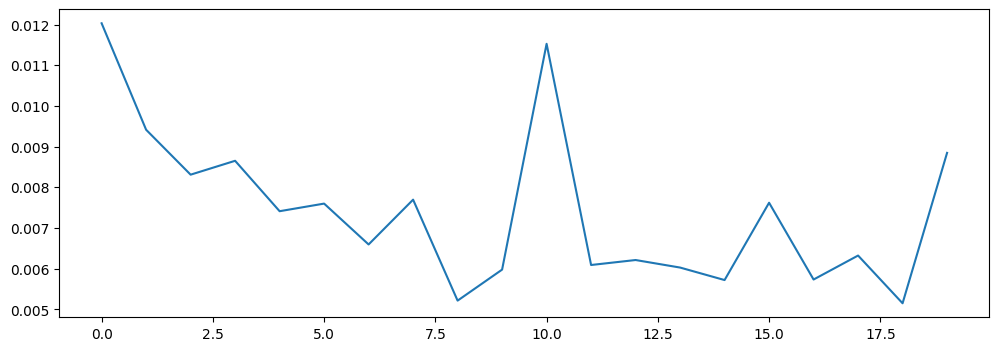

In [8]:
loss = train_autoencoder(
    model=autoencoder,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.show()

## Test

torch.Size([8, 1, 64, 64])


/var/folders/01/ljq5wf3159543w3273r2npnr0000gn/T/ipykernel_63397/2423624934.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


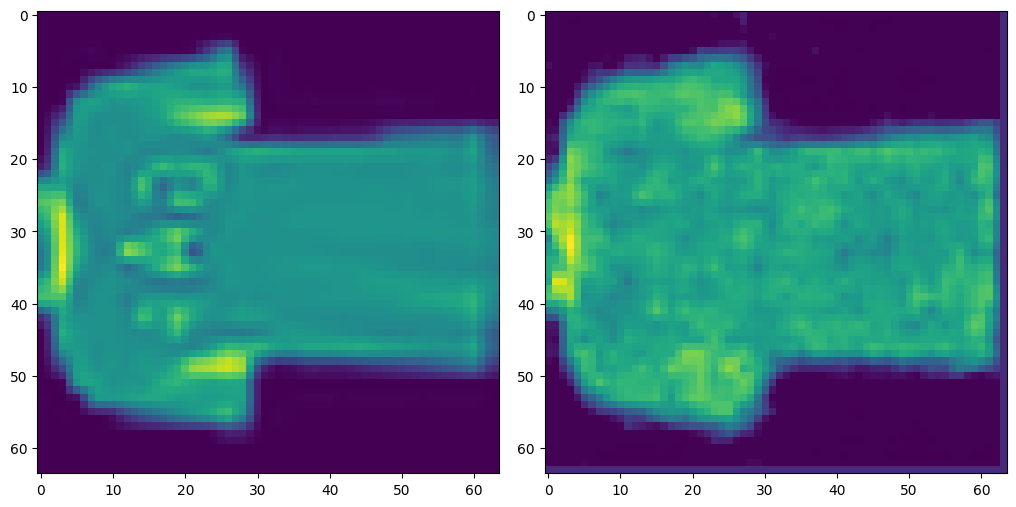

In [17]:
with torch.no_grad():
    for batch, _ in dataloader:
        print(batch.shape)
        pred = autoencoder(batch.to(device))
        im = pred[0]
        im = im[0]
        im = torch.transpose(im, 2, 0)
        im = im.cpu().numpy()

        gt = torch.transpose(batch[0], 2, 0)
        gt = gt.cpu().numpy()

        fig = plt.figure(figsize = (24,6))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(111)
        ax1.imshow(gt)
        ax2.imshow(im)

        fig.show()
        break